## This is Exploratory Data Analysis and Model Selection for the Price Prediction Project

In [58]:
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

#Libraries for multiple regression which I will use for model comparison
from sklearn import linear_model

In [59]:
df = pd.read_csv("best_ever_costs.csv")
df.head(1)
#Will only print out the first row for the sake of protecting the data

,material,per_unit_cost,quantity,complexity_score,surface_area,bounding_box_volume,volume,max_x_length,max_y_length,max_z_length,optimal_fit_on_hp_build_plate
0,ABS-M30,30.67,2,8.951051,"{""units"": ""in^2/"", ""value"": 30.86906387028813}","{""units"": ""in^3/"", ""value"": 21.753358840942383}","{""units"": ""in^3/"", ""value"": 2.392122115044577}","{""units"": ""in"", ""value"": 7.431044101715088}","{""units"": ""in"", ""value"": 2.342428207397461}","{""units"": ""in"", ""value"": 1.2497128248214722}",1046.0


In [3]:
df.shape

(1076, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   material                       1076 non-null   object 
 1   per_unit_cost                  1076 non-null   float64
 2   quantity                       1076 non-null   int64  
 3   complexity_score               832 non-null    float64
 4   surface_area                   1076 non-null   object 
 5   bounding_box_volume            1076 non-null   object 
 6   volume                         1076 non-null   object 
 7   max_x_length                   1076 non-null   object 
 8   max_y_length                   1076 non-null   object 
 9   max_z_length                   1076 non-null   object 
 10  optimal_fit_on_hp_build_plate  798 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 92.6+ KB


In [62]:
#Before I check for outliers or missing values, I have to address certain columns first
#Some columns have units and text before the actual values I want, so I'm going to remove everything that's 
#preceding these values

# #Create two columns for each:
# #This was the old, extremely non-elegant approach
# df['surface_area_units'] = df['surface_area'].apply(lambda x: json.loads(x)['units'])
# df['surface_area_value'] = df['surface_area'].apply(lambda x: json.loads(x)['value'])
# df['bounding_box_volume_units'] = df['bounding_box_volume'].apply(lambda x: json.loads(x)['units'])
# df['bounding_box_volume_value'] = df['bounding_box_volume'].apply(lambda x: json.loads(x)['value'])
# df['max_x_length_units'] = df['max_x_length'].apply(lambda x: json.loads(x)['units'])
# df['max_x_length_value'] = df['max_x_length'].apply(lambda x: json.loads(x)['value'])
# df['volume_units'] = df['volume'].apply(lambda x: json.loads(x)['units'])
# df['volume_value'] = df['volume'].apply(lambda x: json.loads(x)['value'])
# df['max_y_length_units'] = df['max_y_length'].apply(lambda x: json.loads(x)['units'])
# df['max_y_length_value'] = df['max_y_length'].apply(lambda x: json.loads(x)['value'])
# df['max_z_length_units'] = df['max_z_length'].apply(lambda x: json.loads(x)['units'])
# df['max_z_length_value'] = df['max_z_length'].apply(lambda x: json.loads(x)['value'])


#This is significantly better, using way fewer lines of code
#Instead of above, write this
cols = ["surface_area", "bounding_box_volume", "volume", "max_x_length", "max_y_length", "max_z_length"]
newcols = [col + "_value" for col in cols]

df[newcols] = df[cols].applymap(lambda x: json.loads(x)["value"])

cols1 = ["surface_area", "bounding_box_volume", "volume", "max_x_length", "max_y_length", "max_z_length"]
newcols1 = [col + "_units" for col in cols1]

df[newcols1] = df[cols1].applymap(lambda x: json.loads(x)["units"])


#Convert all the mm units
df.loc[df["surface_area_units"] == "in^2/", "surface_area_value"] *= (25.4**2)
df.loc[df["bounding_box_volume_units"] == "in^3", "bounding_box_volume_value"] *= (25.4**3)
df.loc[df["max_x_length_units"] == "in", "max_x_length_value"] *= 25.4
df.loc[df["max_y_length_units"] == "in", "max_y_length_value"] *= 25.4
df.loc[df["max_z_length_units"] == "in", "max_z_length_value"] *= 25.4
df.loc[df["volume_units"] == "in^3", "volume_value"] *= (25.4**3)

In [63]:
#Extra columns are now added to the end
df.head(1)

,material,per_unit_cost,quantity,complexity_score,surface_area,bounding_box_volume,volume,max_x_length,max_y_length,max_z_length,...,volume_value,max_x_length_value,max_y_length_value,max_z_length_value,surface_area_units,bounding_box_volume_units,volume_units,max_x_length_units,max_y_length_units,max_z_length_units
0,ABS-M30,30.67,2,8.951051,"{""units"": ""in^2/"", ""value"": 30.86906387028813}","{""units"": ""in^3/"", ""value"": 21.753358840942383}","{""units"": ""in^3/"", ""value"": 2.392122115044577}","{""units"": ""in"", ""value"": 7.431044101715088}","{""units"": ""in"", ""value"": 2.342428207397461}","{""units"": ""in"", ""value"": 1.2497128248214722}",...,2.392122,188.74852,59.497676,31.742706,in^2/,in^3/,in^3/,in,in,in


In [64]:
#Drop all the columns we no longer need
df = df.drop(["surface_area", 
              "bounding_box_volume", 
              "volume", 
              "max_x_length", 
              "max_y_length", 
              "max_z_length",
              "surface_area_units",
              "bounding_box_volume_units",
              "max_x_length_units",
              "max_y_length_units",
              "max_z_length_units",
              "volume_units"], axis = 1)

In [65]:
#Still have to change "material" column 
#All other object columns that aren't "material" will get dropped later, so they won't cause an issue
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   material                       1076 non-null   object 
 1   per_unit_cost                  1076 non-null   float64
 2   quantity                       1076 non-null   int64  
 3   complexity_score               832 non-null    float64
 4   optimal_fit_on_hp_build_plate  798 non-null    float64
 5   surface_area_value             832 non-null    float64
 6   bounding_box_volume_value      832 non-null    float64
 7   volume_value                   832 non-null    float64
 8   max_x_length_value             832 non-null    float64
 9   max_y_length_value             832 non-null    float64
 10  max_z_length_value             832 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 92.6+ KB


In [66]:
df.describe()

,per_unit_cost,quantity,complexity_score,optimal_fit_on_hp_build_plate,surface_area_value,bounding_box_volume_value,volume_value,max_x_length_value,max_y_length_value,max_z_length_value
count,1076.000000,1076.000000,832.000000,7.980000e+02,8.320000e+02,8.320000e+02,8.320000e+02,832.000000,832.000000,832.000000
mean,490.015502,152.282528,8.225256,1.987327e+05,1.263582e+07,3.386918e+06,4.870516e+05,953.680171,639.257075,590.051518
std,4976.020408,941.027979,1.512760,1.738396e+06,5.022770e+07,1.363711e+07,2.785420e+06,3646.675469,2060.326861,1973.582028
min,0.490000,1.000000,0.000000,0.000000e+00,4.290256e+00,5.157359e-01,7.065584e-02,0.562491,0.562499,0.375000
25%,24.000000,1.000000,7.585075,1.200000e+01,1.574804e+04,1.057144e+03,1.614617e+02,57.373678,39.900024,23.055749
50%,80.000000,2.000000,8.903856,1.750000e+02,5.631184e+04,2.283920e+05,3.157791e+04,126.591507,101.131004,77.249329
75%,264.000000,15.000000,9.079046,1.039000e+03,2.411644e+05,1.612816e+06,2.102480e+05,339.765167,202.061810,207.681991
max,160000.000000,10000.000000,10.332533,3.245873e+07,6.314390e+08,1.791115e+08,4.397511e+07,37541.860425,19354.800000,37541.860425


In [67]:
#There are some extreme outliers, so I will adjust them and bring them
#in the 90% range of the data
maximum = df["per_unit_cost"].quantile(0.9)
df = df[df["per_unit_cost"] < maximum]

maximum2 = df["quantity"].quantile(0.9)
df = df[df["quantity"] < maximum2]

In [68]:
#These columns should not be less extreme
df.describe()

,per_unit_cost,quantity,complexity_score,optimal_fit_on_hp_build_plate,surface_area_value,bounding_box_volume_value,volume_value,max_x_length_value,max_y_length_value,max_z_length_value
count,871.000000,871.000000,688.000000,6.710000e+02,6.880000e+02,6.880000e+02,6.880000e+02,688.000000,688.000000,688.000000
mean,138.923307,7.853042,8.277368,2.342004e+05,9.840514e+06,1.395142e+06,1.905991e+05,819.971607,526.433802,530.494059
std,166.298030,12.349749,1.424171,1.893614e+06,3.793782e+07,3.547577e+06,5.029868e+05,3188.961969,1545.832501,1483.760014
min,0.590000,1.000000,0.000000,0.000000e+00,4.290256e+00,5.157359e-01,7.065584e-02,0.562491,0.562499,0.375000
25%,24.000000,1.000000,7.707934,1.850000e+01,1.705443e+04,3.307566e+02,5.833566e+01,54.357616,40.008477,21.500000
50%,68.280000,2.000000,8.925279,2.150000e+02,5.116693e+04,2.042921e+05,2.472829e+04,117.649246,101.131004,76.749428
75%,184.255000,10.000000,9.072733,1.271500e+03,1.523180e+05,1.016822e+06,1.532640e+05,298.837509,188.082424,177.897614
max,783.000000,56.000000,10.332533,3.245873e+07,3.100713e+08,4.961630e+07,7.986477e+06,37425.731079,10779.249023,11653.525116


In [69]:
#I want to see how many unique "material" options there are
#and how frequent each one is
df["material"].value_counts()

ABS-M30       247
ABS           241
ASA           102
PC-ABS         61
Ultem 9085     60
Ultem 1010     42
PC             34
PC-ISO         29
Nylon 12       22
ABS-ESD7       16
PPSF           10
Pekk            2
Nylon 12CF      2
Nylon 6         1
ABS-M30i        1
ST-130          1
Name: material, dtype: int64

In [70]:
#I also want to see how many values are missing
df.isna().mean()

material                         0.000000
per_unit_cost                    0.000000
quantity                         0.000000
complexity_score                 0.210103
optimal_fit_on_hp_build_plate    0.229621
surface_area_value               0.210103
bounding_box_volume_value        0.210103
volume_value                     0.210103
max_x_length_value               0.210103
max_y_length_value               0.210103
max_z_length_value               0.210103
dtype: float64

In [71]:
#It appears that a lot of rows are missing the same values
#This tells us that a lot of these rows don't containt a lot of data,
#so intead of trying to fill in the NaN's, I will drop a supset of one of
#these rows and see if that eliminates the majority of my missing values.
#If it does, then that means that my assumption was correct, and all these
#rows had the same data missing
df = df.dropna(subset = ["volume_value"])

In [73]:
#Now I can check for outliers and missing values
df.isna().mean()

material                         0.000000
per_unit_cost                    0.000000
quantity                         0.000000
complexity_score                 0.000000
optimal_fit_on_hp_build_plate    0.024709
surface_area_value               0.000000
bounding_box_volume_value        0.000000
volume_value                     0.000000
max_x_length_value               0.000000
max_y_length_value               0.000000
max_z_length_value               0.000000
dtype: float64

In [74]:
#Only one column has nans, and there are a few of them.
#From the above .describe() we can see that this specific column doesn't
#have the meand and std within range of each other.
#This tells us that filling the NaN's in with the .mean() isn't a good approach.
#Instead I'll use .interpolate()
df = df.interpolate(limit_direction = "both")

In [75]:
#There should be no NaN's left
df.isna().mean()

material                         0.0
per_unit_cost                    0.0
quantity                         0.0
complexity_score                 0.0
optimal_fit_on_hp_build_plate    0.0
surface_area_value               0.0
bounding_box_volume_value        0.0
volume_value                     0.0
max_x_length_value               0.0
max_y_length_value               0.0
max_z_length_value               0.0
dtype: float64

In [77]:
#Last thing left to do is encode the "material" values
#Since I am applying the encoding to the entire df, rather than after the
#spplit has been made, I will use .get_dummies(), and concat the dummie
#columns to the original df table
df_dummie = pd.get_dummies(df["material"])
df = pd.concat([df, df_dummie], axis = 1)
df = df.drop("material", axis = 1)
df.head(1)

,per_unit_cost,quantity,complexity_score,optimal_fit_on_hp_build_plate,surface_area_value,bounding_box_volume_value,volume_value,max_x_length_value,max_y_length_value,max_z_length_value,...,Nylon 12CF,Nylon 6,PC,PC-ABS,PC-ISO,PPSF,Pekk,ST-130,Ultem 1010,Ultem 9085
0,30.67,2,8.951051,1046.0,19915.485247,21.753359,2.392122,188.74852,59.497676,31.742706,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#Since I will most likely end up using the decision tree model, followed by
#random forest, I will not use L1 regularization since it is not necessary for 
#this method.

#All that's left now is to separate the data into X and y and train and test

X = df.iloc[:, df.columns != "per_unit_cost"]

y = df["per_unit_cost"]

## Decision Tree

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = DecisionTreeRegressor(random_state = 100)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [80]:
y_pred = model.predict(X_test)

In [81]:
df1 = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df1

,Actual,Predicted
329,426.15,435.75
998,48.00,35.10
289,36.80,18.41
392,3.47,40.00
371,434.00,592.00
...,...,...
981,88.00,58.00
78,549.60,424.45
12,63.70,39.40
1050,264.00,360.00


In [82]:
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Square Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  42.56089371980677
Mean Square Error:  10095.921537560385
Root Mean Square Error:  100.47846305333489


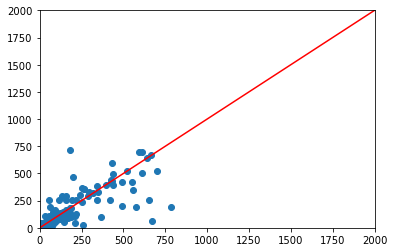

In [83]:
#This can show me a better idea of my error
x1, y1 = [0, 2000], [0, 2000]
plt.plot(x1, y1, "r-")
plt.scatter(y_test,y_pred)
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.show()

## Multiple Regression

Will use linear regression just to compare the results against the decision tree, so I can make sure that decison tree really is the best approach 

In [84]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [85]:
y_pred = regr.predict(X_test)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = DecisionTreeRegressor(random_state = 100)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [86]:
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

,Actual,Predicted
329,426.15,1140.915103
998,48.00,147.445210
289,36.80,71.835519
392,3.47,64.296733
371,434.00,472.778592
...,...,...
981,88.00,85.812209
78,549.60,385.934351
12,63.70,97.010343
1050,264.00,236.263155


In [87]:
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Square Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  92.5576711561195
Mean Square Error:  17670.99944652201
Root Mean Square Error:  132.93231152177415


In [88]:
#Since the error is higher, I will proceed with the decision tree

# Random Forest

In [89]:
from sklearn.ensemble import RandomForestRegressor

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [91]:
clf = RandomForestRegressor(n_estimators = 1000, min_samples_split = 2)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [92]:
y_pred = clf.predict(X_test)
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

,Actual,Predicted
329,426.15,506.223440
998,48.00,42.424230
289,36.80,32.296080
392,3.47,13.264573
371,434.00,507.338970
...,...,...
981,88.00,73.380560
78,549.60,374.682630
12,63.70,49.307840
1050,264.00,325.422051


In [94]:
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Square Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  39.214198978088305
Mean Square Error:  6941.145513375594
Root Mean Square Error:  83.31353739564534


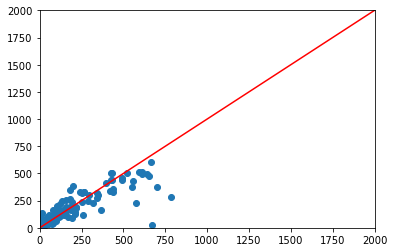

In [95]:
x1, y1 = [0, 2000], [0, 2000]
plt.plot(x1, y1, "r-")
plt.scatter(y_test,y_pred)
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.show()